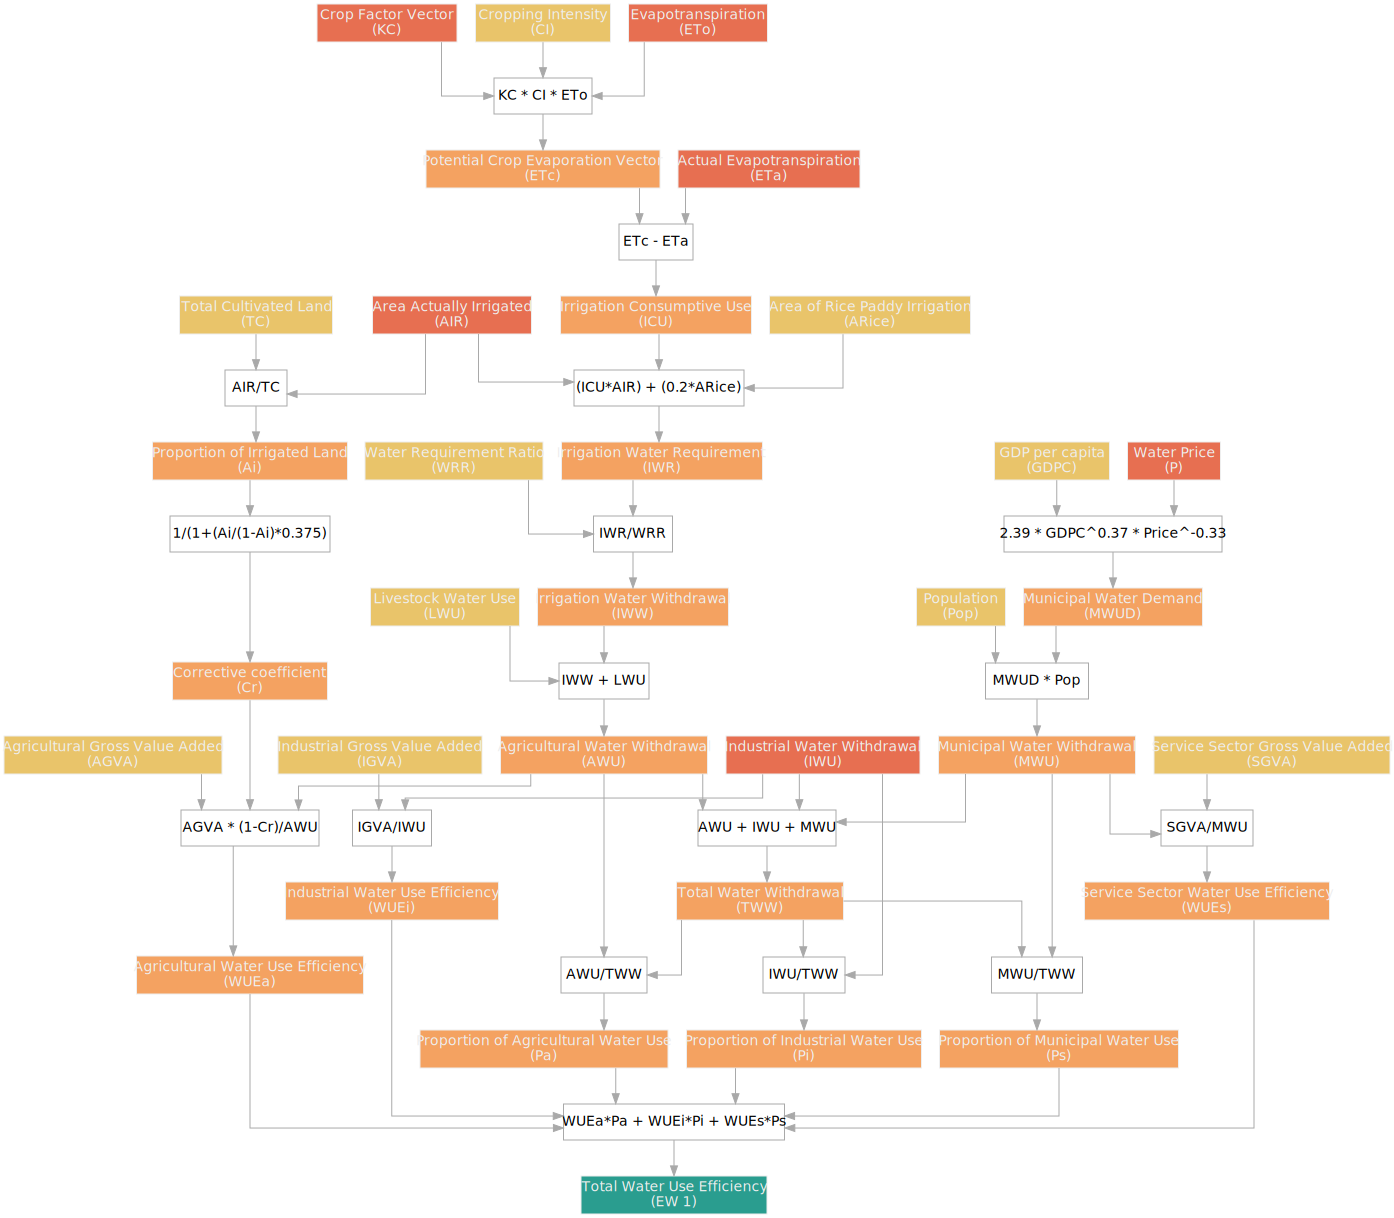

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

__publisher__ = 'Global Green Growth Institute'
__author__ = 'GGPM Team'
__model_lead__ = 'S. Patricia Gerrard'
__programmer__ = 'S. Zabrocki'
__status__ = 'Validated'

"""
TO DO.
"""

"""
Agricultural Water Use

All water metrics from FAO data needed to be converted to 10^9 before modelling
For future projections we can assume there will not be a change in type of crops.
"""

from graphmodels.graphmodel import GraphModel



AgriculturalWaterNodes = [
    {
        'type': 'input',
        'unit': '',
        'name': 'Crop Factor Vector',
        'id': 'KC',
    },
    {
        'type': 'parameter',
        'unit': '%',
        'name': 'Cropping Intensity',
        'id': 'CI',
    },
    {
        'type': 'input',
        'unit': 'mm/year',
        'name': 'Evapotranspiration',
        'id': 'ETo',
    },
    {
        'type': 'variable',
        'name': 'Potential Crop Evaporation Vector',
        'unit': 'mm/year',
        'in': ['KC', 'ETo', 'CI'],
        'computation': {'name': 'KC * CI * ETo', 'formula': lambda X: X['KC'] * X['CI'] * X['ETo']},
        'id': 'ETc',
    },
    {
        'type': 'input',
        'unit': 'mm/year',
        'name': 'Actual Evapotranspiration',
        'id': 'ETa',
    },
    {
        'type': 'variable',
        'name': 'Irrigation Consumptive Use',
        'unit': 'mm/year',
        'in': ['ETc', 'ETa'],
        'computation': {'name': 'ETc - ETa', 'formula': lambda X: X['ETc'] - X['ETa']},
        'id': 'ICU',
    },
    {
        'type': 'input',
        'unit': 'ha (1000)',
        'name': 'Area Actually Irrigated',
        'id': 'AIR',
    },
    {
        'type': 'parameter',
        'unit': 'ha (1000)',
        'name': 'Area of Rice Paddy Irrigation',
        'id': 'ARice',
    },
    {
        'type': 'variable',
        'name': 'Irrigation Water Requirement',
        'unit': 'm3/year',
        'in': ['ICU', 'AIR', 'ARice'],
        'computation': {'name': '(ICU*AIR) + (0.2*ARice) ',
                        'formula': lambda X: sum(X['ICU'] * X['AIR'] + X['ARice'] * 0.2)},
        'id': 'IWR',
    },
    {
        'type': 'parameter',
        'name': 'Water Requirement Ratio',
        'unit': '',
        'id': 'WRR',
    },
    {
        'type': 'variable',
        'name': 'Irrigation Water Withdrawal',
        'unit': 'm3/year',
        'in': ['IWR', 'WRR'],
        'computation': {'name': 'IWR/WRR', 'formula': lambda X: X['IWR'
                                                                  ] / X['WRR']},
        'id': 'IWW',
    },
    {
        'type': 'parameter',
        'name': 'Livestock Water Use',
        'unit': 'm3/year',
        'id': 'LWU',
    },
    {
        'type': 'variable',
        'name': 'Agricultural Water Withdrawal',
        'unit': 'm3/year',
        'in': ['IWW', 'LWU'],
        'computation': {'name': 'IWW + LWU', 'formula': lambda X:
                        X['IWW'] + X['LWU']},
        'id': 'AWU',
    },
    {
        'type': 'input',
        'name': 'Industrial Water Withdrawal',
        'unit': 'm3/year',
        'id': 'IWU',
    },
    {
        'type': 'input',
        'name': 'Water Price',
        'unit': '$/15m3',
        'id': 'P',
    },
    {
        'type': 'parameter',
        'name': 'GDP per capita',
        'unit': '$',
        'id': 'GDPC',
    },
    {
        'type': 'variable',
        'name': 'Municipal Water Demand',
        'unit': 'm3/year/person',
        'in': ['P', 'GDPC'],
        'computation': {'name': '2.39 * GDPC^0.37 * Price^-0.33 ',
                        'formula': lambda X: 2.39 * X['GDPC'] ** 0.37 * X['P'] ** -0.33},
        'id': 'MWUD',
    },
    {
        'type': 'parameter',
        'name': 'Population',
        'unit': 'millions',
        'id': 'Pop',
    },
    {
        'type': 'variable',
        'name': 'Municipal Water Withdrawal',
        'unit': 'm3/year',
        'in': ['Pop', 'MWUD'],
        'computation': {'name': 'MWUD * Pop ', 'formula': lambda X:
                        X['MWUD'] * X['Pop']},
        'id': 'MWU',
    },
    {
        'type': 'variable',
        'name': 'Total Water Withdrawal',
        'unit': 'm3/year',
        'in': ['MWU', 'AWU', 'IWU'],
        'computation': {'name': 'AWU + IWU + MWU', 'formula': lambda X:
                        X['AWU'] + X['IWU'] + X['MWU']},
        'id': 'TWW',
    },
    {
        'type': 'parameter',
        'unit': 'ha (1000)',
        'name': 'Total Cultivated Land',
        'id': 'TC',
    },
    {
        'type': 'variable',
        'name': 'Proportion of Irrigated Land',
        'unit': '',
        'in': ['AIR', 'TC'],
        'computation': {'name': 'AIR/TC', 'formula': lambda X: X['AIR'] / X['TC']},
        'id': 'Ai',
    },
    {
        'type': 'variable',
        'name': 'Corrective coefficient',
        'unit': '',
        'in': ['Ai'],
        'computation': {'name': '1/(1+(Ai/(1-Ai)*0.375)',
                        'formula': lambda X: 1 / (1 + X['Ai'] / (1 - X['Ai']) * 0.375)},
        'id': 'Cr',
    },
    {
        'type': 'parameter',
        'name': 'Agricultural Gross Value Added',
        'unit': '$',
        'id': 'AGVA',
    },
    {
        'type': 'variable',
        'name': 'Agricultural Water Use Efficiency',
        'unit': '$/m3',
        'in': ['AGVA', 'Cr', 'AWU'],
        'computation': {'name': 'AGVA * (1-Cr)/AWU',
                        'formula': lambda X: X['AGVA'] * (1 - X['Cr']) / X['AWU']},
        'id': 'WUEa',
    },
    {
        'type': 'parameter',
        'name': 'Industrial Gross Value Added',
        'unit': '$',
        'id': 'IGVA',
    },
    {
        'type': 'variable',
        'name': 'Industrial Water Use Efficiency',
        'unit': '$/m3',
        'in': ['IGVA', 'IWU'],
        'computation': {'name': 'IGVA/IWU', 'formula': lambda X: X['IGVA'] / X['IWU']},
        'id': 'WUEi',
    },
    {
        'type': 'parameter',
        'name': 'Service Sector Gross Value Added',
        'unit': '$',
        'id': 'SGVA',
    },
    {
        'type': 'variable',
        'name': 'Service Sector Water Use Efficiency',
        'unit': '$/m3',
        'in': ['SGVA', 'MWU'],
        'computation': {'name': 'SGVA/MWU', 'formula': lambda X: X['SGVA'] / X['MWU']},
        'id': 'WUEs',
    },
    {
        'type': 'variable',
        'name': 'Proportion of Agricultural Water Use',
        'unit': '',
        'in': ['AWU', 'TWW'],
        'computation': {'name': 'AWU/TWW', 'formula': lambda X: X['AWU'] / X['TWW']},
        'id': 'Pa',
    },
    {
        'type': 'variable',
        'name': 'Proportion of Industrial Water Use',
        'unit': '',
        'in': ['IWU', 'TWW'],
        'computation': {'name': 'IWU/TWW', 'formula': lambda X: X['IWU'] / X['TWW']},
        'id': 'Pi',
    },
    {
        'type': 'variable',
        'name': 'Proportion of Municipal Water Use',
        'unit': '%',
        'in': ['MWU', 'TWW'],
        'computation': {'name': 'MWU/TWW', 'formula': lambda X: X['MWU'] / X['TWW']},
        'id': 'Ps',
    },
    {
        'type': 'output',
        'name': 'Total Water Use Efficiency',
        'unit': '$/m3',
        'in': [
            'WUEa',
            'Pa',
            'WUEi',
            'Pi',
            'WUEs',
            'Ps',
        ],
        'computation': {'name': 'WUEa*Pa + WUEi*Pi + WUEs*Ps',
                        'formula': lambda X: X['WUEa'] * X['Pa'] + X['WUEi'] * X['Pi'] + X['WUEs'] * X['Ps']},
        'id': 'EW 1',
    },
]

GraphModel(AgriculturalWaterNodes).draw()

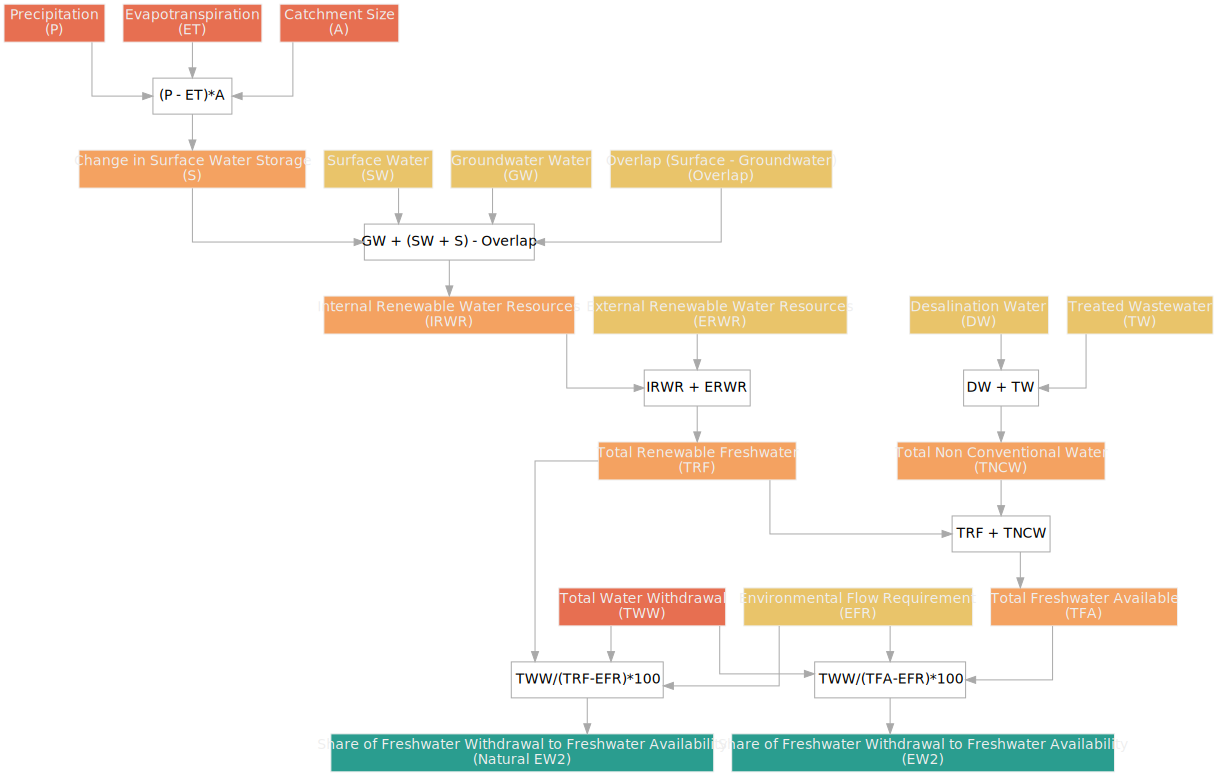

In [2]:
"""
Freshwater Available

Short description of input/outputs assumptions etc etc
"""

FreshwaterAvailableNodes = [
    {'type': 'input',
     'unit': 'mm/year',
        'name': 'Precipitation',
     'id': 'P'},
    {'type': 'input',
     'unit': 'mm/year',
        'name': 'Evapotranspiration',
     'id': 'ET'},
    {'type': 'input',
     'unit': 'ha',
        'name': 'Catchment Size',
     'id': 'A'},
    {'type': 'variable',
     'name': 'Change in Surface Water Storage',
     'unit': 'mm/year',  # need to look into conversion of units think it would be m3/year
     'in': ['P', 'ET', 'A'],
     'computation': {'name': '(P - ET)*A', 'formula': lambda X: (X['P'] - X['ET']) * X['A']},
     'id': 'S'},

    # Renewable Water Resources
    {'type': 'parameter',
        'unit': 'm3/year',
        'name': 'Surface Water',
     'id': 'SW'},
    {'type': 'parameter',
        'unit': 'm3/year',
        'name': 'Groundwater Water',
     'id': 'GW'},
    {'type': 'parameter',
        'unit': 'm3/year',
        'name': 'Overlap (Surface - Groundwater)',
     'id': 'Overlap'},
    {'type': 'variable',
     'name': 'Internal Renewable Water Resources',
     'unit': 'm3/year',
     'in': ['SW', 'GW', 'Overlap', 'S'],
     'computation': {'name': 'GW + (SW + S) - Overlap', 'formula': lambda X: X['GW'] + (X['SW'] - X['S']) - X['Overlap']},
     'id': 'IRWR'},
    {'type': 'parameter',
        'unit': 'm3/year',
        'name': 'External Renewable Water Resources',
     'id': 'ERWR'},
    {'type': 'variable',
     'name': 'Total Renewable Freshwater',
     'unit': 'm3/year',
     'in': ['IRWR', 'ERWR'],
     'computation': {'name': 'IRWR + ERWR', 'formula': lambda X: X['IRWR'] + X['ERWR']}, 'id': 'TRF'},

    # Non conventional water
    {'type': 'parameter',
        'unit': 'm3/year',
        'name': 'Desalination Water',
     'id': 'DW'},
    {'type': 'parameter',
        'unit': 'm3/year',
        'name': 'Treated Wastewater',
        'id': 'TW'},
    {'type': 'variable',
     'name': 'Total Non Conventional Water',
     'unit': 'm3/year',
     'in': ['DW', 'TW'],
     'computation': {'name': 'DW + TW', 'formula': lambda X: X['DW'] + X['TW']}, 'id': 'TNCW'},
    {'type': 'variable',
        'name': 'Total Freshwater Available',
        'unit': 'm3/year',
        'in': ['TRF', 'TNCW'],
        'computation': {'name': 'TRF + TNCW', 'formula': lambda X: X['TRF'] + X['TNCW']}, 'id': 'TFA'},

    # calculation of EW 2
    # input from water use model
    {'type': 'input',
        'unit': 'm3/year',
        'name': 'Total Water Withdrawal',
     'id': 'TWW'},
    {'type': 'parameter',
     'unit': 'm3/year',
        'name': 'Environmental Flow Requirement',
     'id': 'EFR'},

    # inclusion of both natural and non-conventional water sources
    {'type': 'output',
     'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
     'unit': '%',
     'in': ['TFA', 'TWW', 'EFR'],
     'computation': {'name': 'TWW/(TFA-EFR)*100', 'formula': lambda X: X['TWW'] / (X['TFA'] - X['EFR']) * 100}, 'id': 'EW2'},

    # only natural water sources
    {'type': 'output',
     'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
     'unit': '%',
     'in': ['TRF', 'TWW', 'EFR'],
     'computation': {'name': 'TWW/(TRF-EFR)*100', 'formula': lambda X: X['TWW'] / (X['TRF'] - X['EFR']) * 100}, 'id': 'Natural EW2'},

]

GraphModel(FreshwaterAvailableNodes).draw()


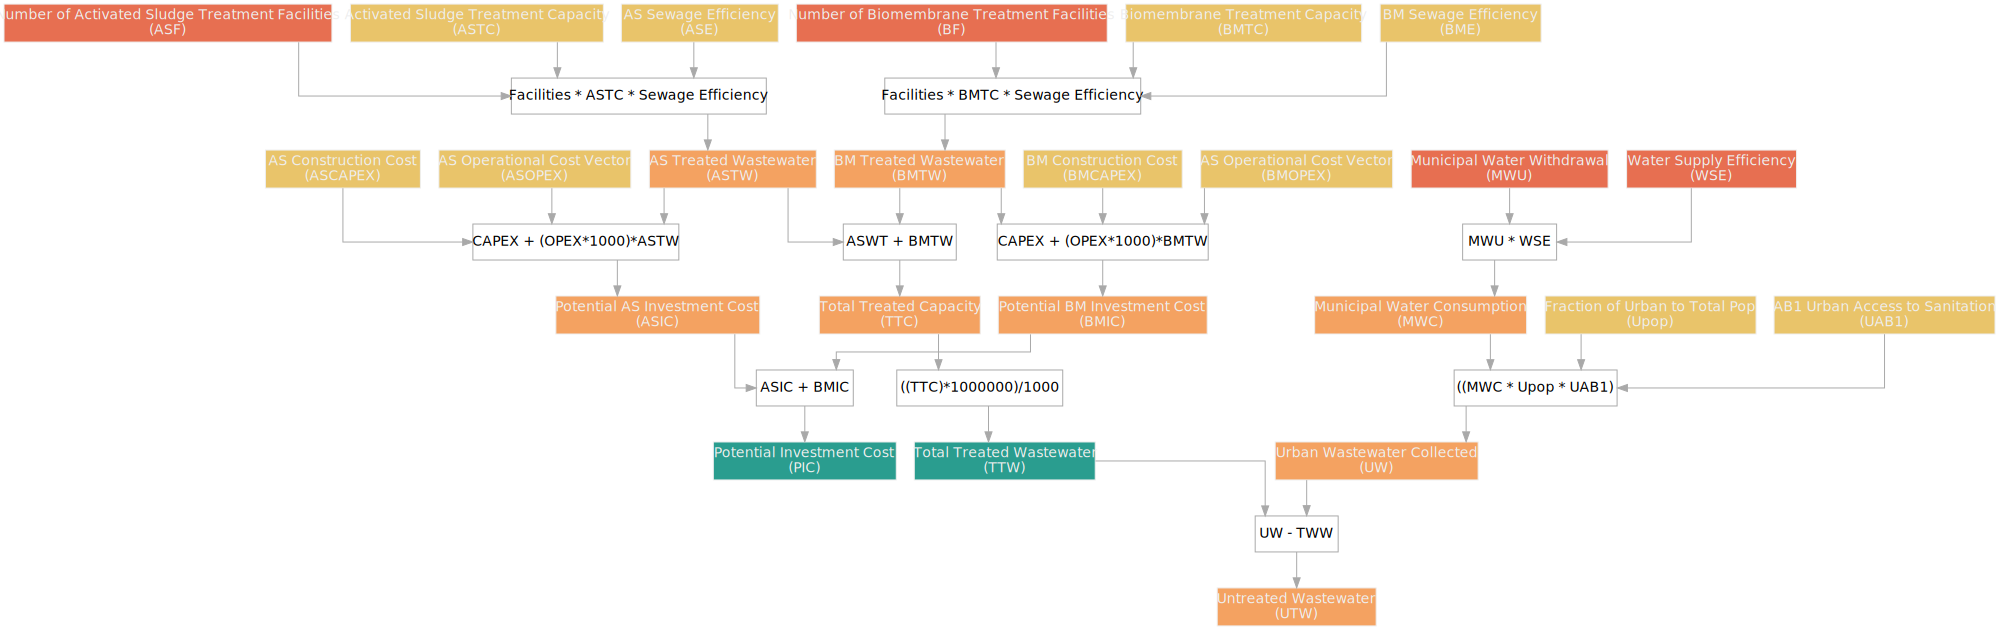

In [3]:
"""
Municipal Water

Short description of input/outputs assumptions etc etc
"""

MunicipalWaterNodes = [
    {'type': 'input',
     'name': 'Municipal Water Withdrawal',  # should be connecting to MWU variable from first water use model
     'unit': 'm3/year',
     'id': 'MWU'},

    {'type': 'input',
     'name': 'Water Supply Efficiency',  # can also be a parameter if we want to keep constant
     'unit': '',
     'id': 'WSE'},

    {'type': 'variable',
     'name': 'Municipal Water Consumption',
     'unit': 'm3/year',
     'in': ['MWU', 'WSE'],
     'computation': {'name': 'MWU * WSE', 'formula': lambda X: X['MWU'] * X['WSE']}, 'id': 'MWC'},

    # Identifying proportion of urban population with sanitation
    {'type': 'parameter',
     'name': 'Fraction of Urban to Total Pop',
     'unit': '',
     'id': 'Upop'},

    {'type': 'parameter',  # should be the output value from the AB1 indicator model
     'name': 'AB1 Urban Access to Sanitation',
     'unit': '',
     'id': 'UAB1'},

    {'type': 'variable',
     # current only consider wastewater from urban areas, could include rural by using same methodology above
     'name': ' Urban Wastewater Collected',
     'unit': 'm3',
     'in': ['MWC', 'Upop', 'UAB1'],
     'id': 'UW',
     'computation': {'name': '((MWC * Upop * UAB1)', 'formula': lambda X: X['MWC'] * X['Upop'] * X['UAB1']}},

    # Wastewater treatment scenario
    {'type': 'input',
     'name': 'Number of Activated Sludge Treatment Facilities',
     'unit': '',
     'id': 'ASF'},
    {'type': 'parameter',
     'name': 'Activated Sludge Treatment Capacity',
     'unit': 'kilotons',
     'id': 'ASTC'},
    {'type': 'parameter',
     'name': 'AS Sewage Efficiency',
     'unit': '',
     'id': 'ASE'},
    {'type': 'variable',
     'name': 'AS Treated Wastewater',
     'unit': 'kilotons',
     'in': ['ASF', 'ASTC', 'ASE'],
     'id': 'ASTW',
     'computation': {'name': 'Facilities * ASTC * Sewage Efficiency ', 'formula': lambda X: X['ASF'] * X['ASTC'] * X['ASE']}},

    {'type': 'input',
     'name': 'Number of Biomembrane Treatment Facilities',
     'unit': '',
     'id': 'BF'},
    {'type': 'parameter',
     'name': 'Biomembrane Treatment Capacity',
     'unit': 'kilotons',
     'id': 'BMTC'},
    {'type': 'parameter',
     'name': 'BM Sewage Efficiency',
     'unit': '',
     'id': 'BME'},
    {'type': 'variable',
     'name': 'BM Treated Wastewater',
     'unit': 'kilotons',
     'in': ['BF', 'BMTC', 'BME'],
     'id': 'BMTW',
     'computation': {'name': 'Facilities * BMTC * Sewage Efficiency', 'formula': lambda X: X['BF'] * X['BMTC'] * X['BME']}},

    {'type': 'variable',
     'name': 'Total Treated Capacity',
     'unit': 'kilotons',
     'in': ['ASTW', 'BMTW'],
     'id': 'TTC',
     'computation': {'name': 'ASWT + BMTW', 'formula': lambda X: X['ASTW'] + X['BMTW']}},


    # converting from kiloton -> kg -> m3 - this will be the input for the Total Treated Wastewater in the Freshwater Availability part of the model
    {'type': 'output',
     'name': 'Total Treated Wastewater',
     'unit': 'm3/year',
     'in': ['TTC'],
     'id': 'TTW',
     'computation': {'name': '((TTC)*1000000)/1000', 'formula': lambda X: X['TTC'] * 1000000 / 1000}},

    # amount of investment required per technology
    {'type': 'parameter',
     'name': 'AS Construction Cost',
     'unit': '$',
     'id': 'ASCAPEX'},

    {'type': 'parameter',
     'name': 'AS Operational Cost Vector',
     'unit': '$/ton',
     'id': 'ASOPEX'},

    {'type': 'variable',
     'name': 'Potential AS Investment Cost',
     'unit': '$',
     'in': ['ASCAPEX', 'ASOPEX', 'ASTW'],
     'id': 'ASIC',
     'computation': {'name': 'CAPEX + (OPEX*1000)*ASTW', 'formula': lambda X: X['ASCAPEX'] + X['ASOPEX'] * 1000 * X['ASTW']}},

    {'type': 'parameter',
        'name': 'BM Construction Cost',
        'unit': '$',
        'id': 'BMCAPEX'},
    {'type': 'parameter',
     'name': 'AS Operational Cost Vector',
     'unit': '$/ton',
     'id': 'BMOPEX'},
    {'type': 'variable',
     'name': 'Potential BM Investment Cost',
     'unit': '$',
     'in': ['BMCAPEX', 'BMOPEX', 'BMTW'],
     'id': 'BMIC',
     'computation': {'name': 'CAPEX + (OPEX*1000)*BMTW', 'formula': lambda X: X['BMCAPEX'] + X['BMOPEX'] * 1000 * X['BMTW']}},

    {'type': 'output',
     'name': 'Potential Investment Cost',
     'unit': '$',
     'in': ['ASIC', 'BMIC'],
     'id': 'PIC',
     'computation': {'name': 'ASIC + BMIC', 'formula': lambda X: X['ASIC'] + X['BMIC']}},

    # amount of untreated wastewater and link to DALY
    {'type': 'variable',
     'name': 'Untreated Wastewater',
     'unit': 'kilotons',
     'in': ['TTW', 'UW'],
     'id': 'UTW',
     'computation': {'name': 'UW - TWW', 'formula': lambda X: X['UW'] - X['TTW']}},

    # for further discussion
    # how untreated wastewater increases the burden of disease -> social cost of pollution
    # comparing the potential investment costs to the social benefit of reducing wastewater pollution.
]

GraphModel(MunicipalWaterNodes).draw()